In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

2026-02-25 12:01:44.542105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772020904.729439      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772020904.780570      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772020905.192453      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772020905.192511      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772020905.192514      23 computation_placer.cc:177] computation placer alr

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 4
EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_CLASSES = 20  # exclude void class

AUTOTUNE = tf.data.AUTOTUNE
DATASET_ROOT = "/kaggle/input/datasets/sajilck/road-segmentation-indian"

In [3]:
CLASS_MAP = {
    "road": 0,
    "sidewalk": 1,
    "building": 2,
    "wall": 3,
    "fence": 4,
    "pole": 5,
    "traffic light": 6,
    "traffic sign": 7,
    "vegetation": 8,
    "terrain": 9,
    "sky": 10,
    "person": 11,
    "rider": 12,
    "car": 13,
    "truck": 14,
    "bus": 15,
    "train": 16,
    "motorcycle": 17,
    "bicycle": 18,
    # void removed
}

In [4]:
CSV_PATH = os.path.join(DATASET_ROOT, "data/index.csv")
df = pd.read_csv(CSV_PATH)[["images", "masks"]]

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    df["images"],
    df["masks"],
    test_size=0.2,
    random_state=42)

In [5]:
def json_to_mask(json_path, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)

    with open(json_path) as f:
        data = json.load(f)

    for obj in data.get("objects", []):

        label = obj.get("label", None)
        if label not in CLASS_MAP:
            continue

        polygon = obj.get("polygon", None)

        # 🔹 Skip invalid polygons
        if polygon is None:
            continue

        if len(polygon) < 3:
            continue

        try:
            polygon = np.array(polygon, dtype=np.int32)

            # Ensure correct shape (N, 2)
            if polygon.ndim != 2 or polygon.shape[1] != 2:
                continue

            cv2.fillPoly(mask, [polygon], CLASS_MAP[label])

        except Exception:
            continue  # Skip corrupted polygons silently

    return mask

In [6]:
def load_image_mask(image_path, mask_path):

    image_path = image_path.decode("utf-8")
    mask_path = mask_path.decode("utf-8")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image.shape[:2]
    mask = json_to_mask(mask_path, orig_h, orig_w)

    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    image = image / 255.0

    return image.astype(np.float32), mask.astype(np.int32)

In [7]:
def tf_load(image_path, mask_path):
    image, mask = tf.numpy_function(
        load_image_mask,
        [image_path, mask_path],
        [tf.float32, tf.int32]
    )
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH])
    return image, mask

In [8]:
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

        # Expand mask to 3D
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.flip_left_right(mask)
        mask = tf.squeeze(mask, axis=-1)

    return image, mask

In [9]:
def build_dataset(image_paths, mask_paths, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(tf_load, num_parallel_calls=AUTOTUNE)

    if training:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(100)

    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [10]:
def ASPP(x, filters=256):

    dims = x.shape

    y1 = layers.Conv2D(filters, 1, padding="same", use_bias=False)(x)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)

    y2 = layers.Conv2D(filters, 3, dilation_rate=6,
                       padding="same", use_bias=False)(x)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)

    y3 = layers.Conv2D(filters, 3, dilation_rate=12,
                       padding="same", use_bias=False)(x)
    y3 = layers.BatchNormalization()(y3)
    y3 = layers.ReLU()(y3)

    y4 = layers.Conv2D(filters, 3, dilation_rate=18,
                       padding="same", use_bias=False)(x)
    y4 = layers.BatchNormalization()(y4)
    y4 = layers.ReLU()(y4)

    y = layers.Concatenate()([y1, y2, y3, y4])
    y = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    return y

In [11]:
def build_deeplabv3plus():

    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Low-level features
    low_level = base_model.get_layer("conv2_block3_out").output
    high_level = base_model.get_layer("conv4_block6_out").output

    # ASPP
    aspp = ASPP(high_level)

    # Upsample ASPP output
    aspp = layers.UpSampling2D(
        size=(4, 4),
        interpolation="bilinear"
    )(aspp)

    # Reduce low-level features
    low_level = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level)
    low_level = layers.BatchNormalization()(low_level)
    low_level = layers.ReLU()(low_level)

    # Concatenate
    x = layers.Concatenate()([aspp, low_level])

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final upsampling
    x = layers.UpSampling2D(
        size=(4, 4),
        interpolation="bilinear"
    )(x)

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    return model

In [12]:
def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=NUM_CLASSES)

    y_true = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred = tf.reshape(y_pred, [-1, NUM_CLASSES])

    intersection = tf.reduce_sum(y_true * y_pred, axis=0)
    denom = tf.reduce_sum(y_true, axis=0) + tf.reduce_sum(y_pred, axis=0)

    dice = (2. * intersection + smooth) / (denom + smooth)

    return 1 - tf.reduce_mean(dice)


def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return ce + dice_loss(y_true, y_pred)

In [13]:
mean_iou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)

def compute_mean_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    mean_iou_metric.update_state(y_true, y_pred)
    return mean_iou_metric.result()

I0000 00:00:1772020928.444552      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
class EarlyStopper(Callback):
    def __init__(self, target):
        super(EarlyStopper, self).__init__()
        self.target = target
    def on_epoch_end(self, epoch, logs={}):
        acc = logs['val_compute_mean_iou']
        if acc >= self.target:
            self.model.stop_training = True

In [15]:
early_stopper = EarlyStopper(0.8)

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_compute_mean_iou",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_compute_mean_iou",
        mode="max",
        factor=0.5,
        patience=3,
        verbose=1
    ),
    early_stopper]

In [17]:
model = build_deeplabv3plus()

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=combined_loss,
    metrics=[compute_mean_iou])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [18]:
train_imgs = DATASET_ROOT+'/'+ train_imgs.astype(str)
train_masks = DATASET_ROOT+'/'+ train_masks.astype(str)
val_imgs = DATASET_ROOT+'/'+ val_imgs.astype(str)
val_masks = DATASET_ROOT+'/'+ val_masks.astype(str)

In [19]:
train_dataset = build_dataset(train_imgs, train_masks, training=True)
val_dataset = build_dataset(val_imgs, val_masks, training=False)

history = model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/100


I0000 00:00:1772020967.196552      63 service.cc:152] XLA service 0x7d7940004330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772020967.196591      63 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1772020972.532527      63 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-25 12:03:09.193501: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.99 = (f32[256,304,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,304,128,128]{3,2,1,0} %bitcast.66787, f32[4,256,128,128]{3,2,1,0} %bitcast.66789), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_1/conv2d_6_1/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=12

802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - compute_mean_iou: 0.1959 - loss: 1.3383
Epoch 1: val_compute_mean_iou improved from -inf to 0.31150, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 399s 411ms/step - compute_mean_iou: 0.1960 - loss: 1.3380 - val_compute_mean_iou: 0.3115 - val_loss: 1.3479 - learning_rate: 1.0000e-04
Epoch 2/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - compute_mean_iou: 0.3214 - loss: 0.9443
Epoch 2: val_compute_mean_iou improved from 0.31150 to 0.35964, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 300s 371ms/step - compute_mean_iou: 0.3214 - loss: 0.9443 - val_compute_mean_iou: 0.3596 - val_loss: 0.8950 - learning_rate: 1.0000e-04
Epoch 3/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - compute_mean_iou: 0.3700 - loss: 0.8672
Epoch 3: val_compute_mean_iou improved from 0.35964 to 0.39335, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 299s 371ms/step - compute_mean_iou: 0.3700 - loss: 0.8672 - val_compute_me

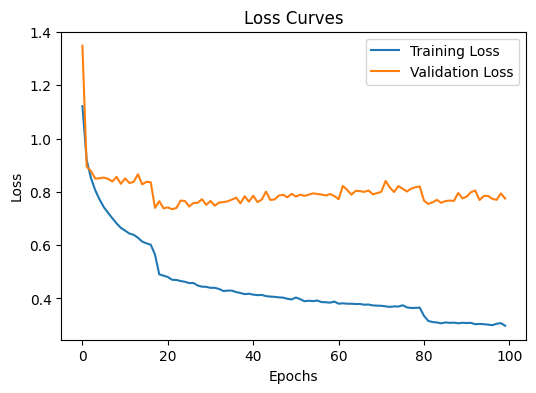

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

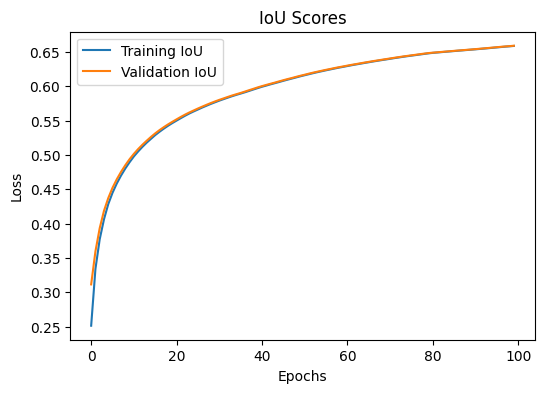

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['compute_mean_iou'], label='Training IoU')
plt.plot(history.history['val_compute_mean_iou'], label='Validation IoU')
plt.title('IoU Scores')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
def load_image_mask2(image_path, mask_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image.shape[:2]
    mask = json_to_mask(mask_path, orig_h, orig_w)

    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    image = image / 255.0

    return image.astype(np.float32), mask.astype(np.int32)

In [23]:
def visualize_sample(index=0):

    image_path = val_imgs.values[index]
    mask_path = val_masks.values[index]

    image, mask = load_image_mask2(image_path, mask_path)

    pred = model.predict(np.expand_dims(image, axis=0))[0]

    pred = np.argmax(pred, axis=-1)
    mask = np.argmax(mask, axis=-1)

    plt.figure(figsize=(9,5))

    plt.subplot(1,2,1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.title("Prediction")
    plt.imshow(pred)

    plt.show()

450
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


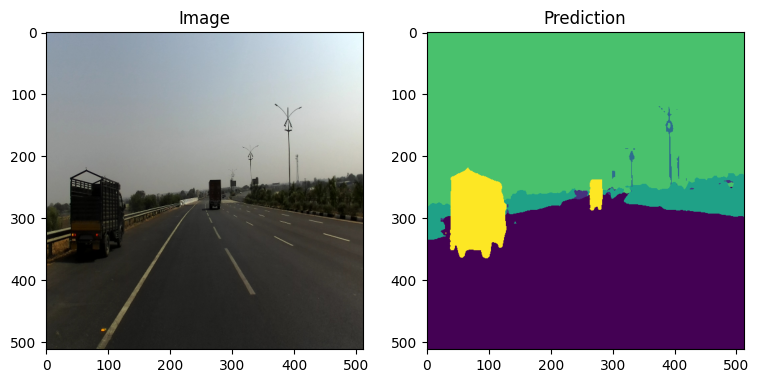

435
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


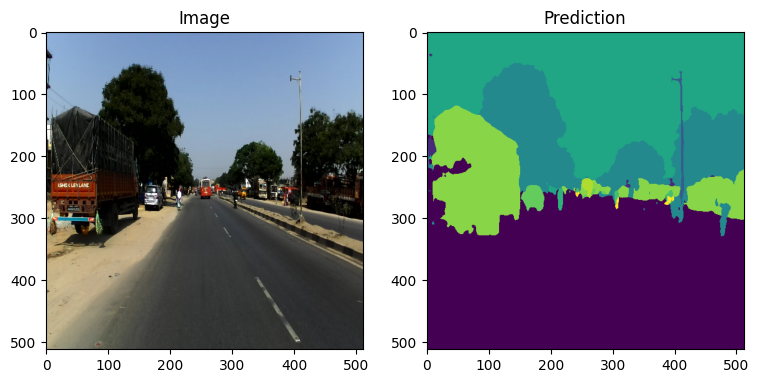

460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


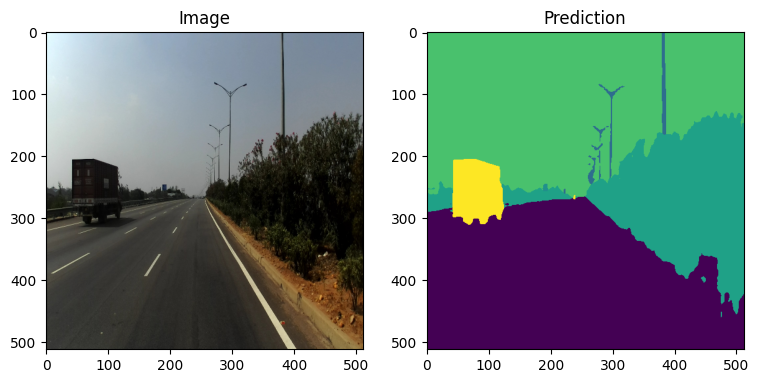

270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


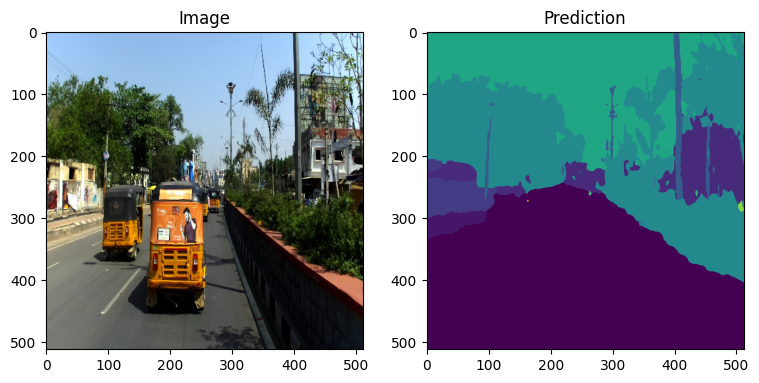

175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


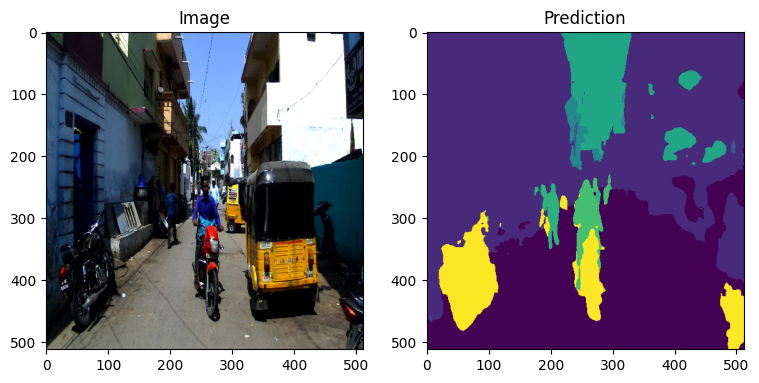

In [24]:
for i in np.random.randint(1,500, 5):
    print(i)
    visualize_sample(i)